#   **Multilingual Banking Chatbot** -End to End NLP Pipeline

As a result of the wide variety of multi international languages spoken by customers in our banking sector. It is really challenging to provide consistent, fast, and accurate support to the customer. Our Manual handling is slow, error-prone, and not scalable.

**Business Development:**
It is our goal to develop a multilingual banking chatbot that would be able to categorize user queries according to their intent and respond in the language of the user (currently we are handling only in English). Our banking system planned to develop the 200+ langugaes chatbot support, before that ***we are planning to execute the German and Tamil language chatbot due to the large customer encagement***.  It reduces customer service agents' workload and ensures quick and multilingual support.

**Business Benefits**
1. 24 * 7 Automated support
2. Support cost reduction
3. Faster resolution
4. Higher Statification

**Data Collection** Manually collected and augmented into 3 languages and stored as
https://www.kaggle.com/datasets/manojajj/banking-chatbot
https://www.kaggle.com/datasets/udaymalviya/bank-loan-data?resource=download
https://www.kaggle.com/datasets/manojajj/banking-chatbot

All code and dataset are stored in https://github.com/NithyeshSakthi/nlp-chatbot-data

we collected 3 datasets 1. which we used for greetings *Datasets/greetings_en.csv* 2.for laon queries *Datasets/loan_data.cs*v 3. for ususal bank queries *Datasets/Dataset_Banking_chatbot.csv*

I have altered the data and stored in the Datasets/*final_banking_data_translated.csv* after the issues with the wrong translation we fixed here  *nlp-chatbot-data/code
/Dataset-Internatioanl_banking_data_chatbot.ipynb*

**High-Level System Design**

- Data Ingestion: CSV file with multilingual queries and intents

- Text Preprocessing: Clean, tokenize, lemmatize queries

- Feature Engineering: TF-IDF vectorization

- Intent Modeling: Train a classifier (Multinomial Naive Bayes)

- Relabeling Module: Fix unknown intents using keyword rules + similarity

- Response Generation: Return appropriate multilingual response

- Evaluation: Classification metrics + confusion matrix

# 1.Imports & Setup
Load necessary packages and tools mainly to run the datavisualization, preprocessing, data handling and model trainng


In [20]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import json

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Downloaded necessary NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# 2. Load the Dataset
Here we expand the columns what my chatbot CSV file contains

In [46]:
df = pd.read_csv("/content/Internatioanl_banking_data_chatbot.csv")  # Ensure expected columns exist
print(df.columns)

Index(['Query', 'Response', 'language', 'intent', 'Response_DE',
       'Response_TA'],
      dtype='object')


# 3. Text Cleaning & Preprocessing
This cleaning and preprocessing includes the cleaning the text and its takes for traing and matching

In [47]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith("J"): return wordnet.ADJ
    elif tag.startswith("V"): return wordnet.VERB
    elif tag.startswith("N"): return wordnet.NOUN
    elif tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

def preprocess(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tagged = pos_tag(tokens)
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(p)) for w, p in tagged])

df["clean_text"] = df["Query"].astype(str).apply(preprocess)


# 4. EDA (Exploratory Data Analysis)
Detects the imabalces betweeen the class labels like loan_info, Grettings, goodbuy.

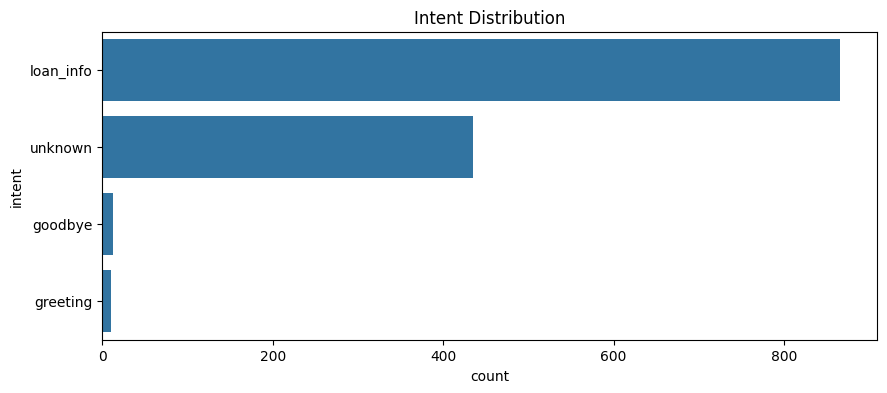

In [48]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, y="intent", order=df["intent"].value_counts().index)
plt.title("Intent Distribution")
plt.show()

# 5. Relabel Misclassified unknown Intents (Positioned After EDA)
Here 400+ unknown misclassified samples are labled so here we apply the rule for pre labe;ing

In [56]:
# 1. Manual relabeling based on patterns
df.loc[df["Query"].str.contains("credit report", case=False), "intent"] = "account_info"
df.loc[df["Query"].str.contains("wire transfer", case=False), "intent"] = "fees_info"
df.loc[df["Query"].str.contains("branch hours", case=False), "intent"] = "account_info"

# 2. Similarity-based relabeling (semi-automatic)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

known = df[df["intent"] != "unknown"].copy()
unknown = df[df["intent"] == "unknown"].copy()

# Clean NaNs and whitespace
known["clean_text"] = known["clean_text"].fillna("").astype(str).str.strip()
unknown["clean_text"] = unknown["clean_text"].fillna("").astype(str).str.strip()

# Check if there are any unknown samples left before proceeding
if not unknown.empty:
    vectorizer_temp = TfidfVectorizer()
    vectorizer_temp.fit(df["clean_text"])  # Fit on entire dataset

    X_known = vectorizer_temp.transform(known["clean_text"])
    X_unknown = vectorizer_temp.transform(unknown["clean_text"])

    relabels = []
    threshold = 0.4  # Optional similarity threshold

    for i in range(X_unknown.shape[0]):
        similarities = cosine_similarity(X_unknown[i], X_known).flatten()
        best_score = similarities.max()
        if best_score >= threshold:
            intent = known.iloc[similarities.argmax()]["intent"]
        else:
            intent = "unknown"
        relabels.append(intent)
# Apply relabels to the main DataFrame
    df.loc[df["intent"] == "unknown", "intent"] = relabels

# Save relabeling audit log
    unknown["new_intent"] = relabels
    unknown.to_csv("intent_relabel_audit.csv", index=False)
    print(" Relabeling done... Log saved.")
else:
    print("No unknown intents found after manual relabeling. Skipping similarity-based relabeling.")

 Relabeling done. Log saved.


# 6. Vectorization with **TF**-**IDF**
It help to convert from text to number for better understanding for ML

In [50]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9)
X = vectorizer.fit_transform(df["clean_text"])
y = df["intent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

 # 7. Model Training- Mutltinomial Naive Bayes
It helps for intent the unseen queries performance bias the dominante category


In [52]:

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

# 9. Model Evaluation
It X_test generate the predicted intend trained models and compares with the y_pred predicted labels woth the actual lables y_test. Finally it show the visual for the actual and predicted classs

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

account_info       0.00      0.00      0.00         1
     goodbye       0.00      0.00      0.00         3
    greeting       0.00      0.00      0.00         2
   loan_info       0.96      1.00      0.98       174
     unknown       0.99      0.98      0.98        85

    accuracy                           0.97       265
   macro avg       0.39      0.40      0.39       265
weighted avg       0.95      0.97      0.96       265



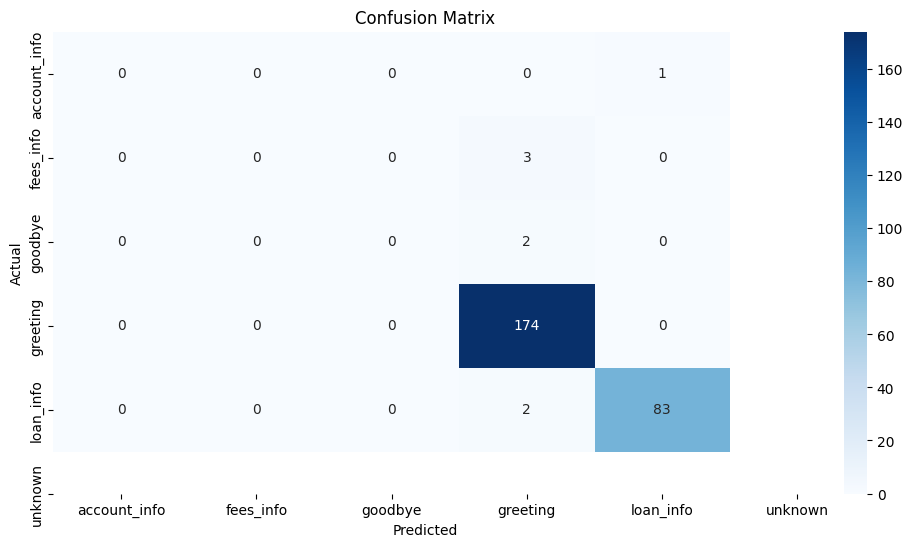

In [53]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 9. Multilingual Chat Function with Confidence Threshold
Important for Chatbot that reconganize the speaker and revert the response. Here, en - English , de- German and ta- Tamil for set the response in the cleanded detected language. is any thing further we add it will revert as "Not understand the code"

In [54]:
def chat(query, reply_language="en"):
    cleaned = preprocess(query)
    vector = vectorizer.transform([cleaned])
    probs = model.predict_proba(vector)[0]
    confidence = max(probs)
    intent = model.classes_[np.argmax(probs)]

    if confidence < 0.5:
        return "Sorry, I couldn't understand that."

    lang_map = {
        "en": "Response",
        "de": "Response_DE",
        "ta": "Response_TA"
    }
    col = lang_map.get(reply_language, "Response")
    responses = df[df["intent"] == intent][col].dropna().tolist()

    return np.random.choice(responses) if responses else "No response available."

# 10. Test It Out!
Final test here we can given the input
1.what lanaguage code we used (EN, DE, TA) ,
2.query intend - which shows where we can take debit, account_info, greeting
3.Finally what type of query we expected


In [55]:
print("EN:", chat("How do I reset my ATM pin?", reply_language="en"))
print("DE:", chat("Wie kann ich mein Konto überprüfen?", reply_language="de"))
print("TA:", chat("எப்படி கடன் பெறலாம்?", reply_language="ta"))

EN: To deny the charge, contact our customer service with the details of the fee and any auxiliary documents.
DE: Um eine Kreditkarte zu beantragen, besuchen Sie unsere Website und füllen Sie das Online -Bewerbungsformular aus oder besuchen Sie eine Filiale, um sich persönlich zu bewerben.
TA: உங்கள் கணக்கு வகையில் மாற்றத்தைக் கோர, வாடிக்கையாளர் சேவையைத் தொடர்பு கொள்ளுங்கள் அல்லது கிடைக்கக்கூடிய விருப்பங்கள் மற்றும் தேவைகளைப் பற்றி விவாதிக்க ஒரு கிளையைப் பார்வையிடவும்.


#Result - For this result we got exact response from the 3 diffrent languages

1. print("EN:", chat("How do I reset my ATM pin?", reply_language="en")) - **Query intend like debit_card , account_info**
2. print("DE:", chat("Wie kann ich mein Konto überprüfen?", reply_language="de")) **Query intend - (How can i check my account) account-info**
3. print("TA:", chat("எப்படி கடன் பெறலாம்?", reply_language="ta")) **Query intend - (Where can i get the loan) Loan-info**

# Challanges
1. Imbalancde and unknown intends - Reclassifed 400+ unknown queries into correct intends.
2. Missplaced Translations - Mixed with the German transaltion with English and Tamil Transations
3. 3 Langauage confusiion in the Dataset - Fixed misplaced responses with Tamil/German.
4. Missing Translation (NaN) - Realtered and replced with columns with the helo of Translator.
5. Wrong predection - Used confident filter to handle the uncertain queries